# Team Information

|Team-number :|  23  |
|:----:|:---:|


|           Name           |           E-Mail           |matriculation-nr.|
|:------------------------:|:--------------------------:|:----:|
|  Jerome, Sweetsy Maria   | jerome02@ads.uni-passau.de |1234567|
| Jerome, Sweety Elizabeth | jerome03@ads.uni-passau.de |2234567|
|     Al Rebdawi, Mays     | alrebd01@ads.uni-passau.de |3234567|
|      Caspari, Laura      | caspar07@ads.uni-passau.de |4234567|

The following cell contains all the imports needed for this notebook. Obviously, we need pandas to load the csv files we want to work with and numpy to work with the data we want to feed into the model. To visualize results, we need matplotlib for all the fancy plots we want to use. The ta import is included to add some standard technical indicators from that library to our data.

To build a neural network, we need the tensorflow imports to get our hands on the desired optimizer, be able to build a model we can train and stack layers into (Sequential) as well as all the layers we would like to use in our model. We also use the keras tuner for hyperparameter optimization for which we use RandomSearch, and import EarlyStopping to stop the training process early in case the validation loss increases. From the sklearn package, we import the MinMaxScaler to rescale out data before feeding it to the model. I've included a gradient boosting regressor to try and estimate future closing prices and used permutation importance and the mean squared error to evaluate this performance using a simple train test split. The time series split is used for training the final model.

This is just a quick overview of the various imports, more details on their usage and reasoning behind their import will be given in the parts of the notebook where they are actually used.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import ta

from keras_tuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

First, let's import the training data from the `train.csv` file and the asset details from `asset_details.csv` and merge the two to, so we have the asset names and weights available in addition to the training data.

In [2]:
pd.options.mode.chained_assignment = None

directory = 'C:/Users/sweet/OneDrive/Desktop/sweety/g-research-crypto-forecasting'
file_path = os.path.join(directory, 'train.csv')
dtypes = {
    'timestamp': np.int64,
    'Asset_ID': np.int8,
     'Count': np.int32,
     'Open': np.float64,
     'High': np.float64,
     'Low': np.float64,
    'Close': np.float64,
     'Volume': np.float64,
     'VWAP': np.float64,
    'Target': np.float64,
}
data = pd.read_csv(file_path, dtype=dtypes, usecols=list(dtypes.keys()))
data['Time'] = pd.to_datetime(data['timestamp'], unit='s')

file_path = os.path.join(directory, 'asset_details.csv')
details = pd.read_csv(file_path)

data = pd.merge(data,
                details,
                on ='Asset_ID',
                how ='left')

print(data.head())
print(details)

    timestamp  Asset_ID  Count        Open        High         Low  \
0  1514764860         2     40   2376.5800   2399.5000   2357.1400   
1  1514764860         0      5      8.5300      8.5300      8.5300   
2  1514764860         1    229  13835.1940  14013.8000  13666.1100   
3  1514764860         5     32      7.6596      7.6596      7.6567   
4  1514764860         7      5     25.9200     25.9200     25.8740   

        Close       Volume          VWAP    Target                Time  \
0   2374.5900    19.233005   2373.116392 -0.004218 2018-01-01 00:01:00   
1      8.5300    78.380000      8.530000 -0.014399 2018-01-01 00:01:00   
2  13850.1760    31.550062  13827.062093 -0.014643 2018-01-01 00:01:00   
3      7.6576  6626.713370      7.657713 -0.013922 2018-01-01 00:01:00   
4     25.8770   121.087310     25.891363 -0.008264 2018-01-01 00:01:00   

     Weight        Asset_Name  
0  2.397895      Bitcoin Cash  
1  4.304065      Binance Coin  
2  6.779922           Bitcoin  
3  1.3

To make training time and memory usage a bit more bearable, let's only consider the currency data starting from 2020 and split it into training and evaluation data.

In [3]:
data_eval = data[data.timestamp >= 1622505660]
data = data[data.timestamp < 1622505660]
data = data[data.timestamp > 1577836800]

Now, before we really dive into the more interesting sections of this notebook, let's first talk about the most problematic part of this task.

### Taking A Closer Look At Our Target Variable

The first approach I've tried at predicting our target was to take a single currency (Bitcoin) and try to predict its target by adding various technical indicators from the **ta** package that exhibited the highest correlation to the target. Overall, I added 18 different indicators for momentum, volume, volatility and trend. I also threw the target column into the mix by shifting it accordingly (which I also do below). I then tried multiple RNN structures for estimation, playing around with GRUs and LSTMs and building deeper models. I even tried adding an autoencoder to see if I could condense the information given in all the features I added to a lower dimension, in the hope that this might improve the model performance. Still, the quality of predictions was lacking and the best correlation I was able to achieve was around 6% for the training, and 5% for the evaluation data.

After looking at different papers trying to predict future bitcoin returns, I was confused why the model seemed to perform that badly. I found multiple papers that seemed to be able to predict e.g. future closing prices with regression or classification tasks quite well by adding some technical indicators to the available data and using neural networks (in principle, not all too different from what I tried). So, I took another look at the target and tried to understand exactly how it is calculated. Well...

So apparently, the target of a currency a is calculated using the following straightforward formulas:
$$Target^a(t) = R^a(t) - \beta^aM(t)$$
$$\beta^a = \frac{\langle M \cdot R^a \rangle}{\langle M^2 \rangle}$$
$$M(t) = \frac{\sum_a w^a R^a(t)}{\sum_a w^a}$$
$$R^a(t) = log (P^a(t+16)\ /\ P^a(t+1))$$

And a good estimation of the target creation is given by the following code taken from [here](https://www.kaggle.com/alexfir/recreating-target#More-optimized-version).

In [4]:
# Take the close column for the log price calculation for R
price_column = 'Close'

ids = list(details.Asset_ID)
asset_names = list(details.Asset_Name)

all_timestamps = np.sort(data['timestamp'].unique())
all_eval_timestamps = np.sort(data_eval['timestamp'].unique())
targets = pd.DataFrame(index = all_timestamps)

for i, id in enumerate(ids):
    asset = data[data.Asset_ID == id].set_index(keys = 'timestamp')
    price = pd.Series(index = all_timestamps, data = asset[price_column])
    # Take the closing price at t+16 and at t+1 to calculate the current R(t)
    targets[asset_names[i]] = (
        price.shift(periods = -16) /
        price.shift(periods = -1)
    ) - 1

weights = np.array(list(details.Weight))
# Calculate M(t) summing up the R(t) values for all currencies calculated before multiplied by their respective weights.
targets['m'] = np.average(targets.fillna(0), axis = 1, weights = weights)

m = targets['m']

# Calculate the M * R(t) part of beta as the rolling average over the next 3750 minutes
num = targets.multiply(m.values, axis = 0).rolling(3750).mean().values
# Calculate the M * M part for beta using a rolling average over the next 3750 minutes
denom = m.multiply(m.values, axis = 0).rolling(3750).mean().values
# Calculate beta
beta = np.nan_to_num(num.T / denom, nan = 0., posinf = 0., neginf = 0.)

# Finally, we can calculate the target. While this seems to be a very good approximation, it's still not the exact way the target is calculated.
target_approximation = targets - (beta * m.values).T

So, all in all, pretty easy. All we need to approximate the target is closing prices from the future for all our currencies, then calculate the current M value based on these and then multiply that with the 3750 minutes moving average beta. Considering this calculation, it is obvious why the predictive ability of the features contained in our data as well as that of standard technical indicators is fairly limited. There's just too much information from all our different currencies that goes into the calculation of the target variable.

After understanding how our target is calculated, I took a different approach. In order to make useful predictions, we need to feed our model some information that is more closely related to our target. So, what if we feed our model information that in theory is not available at that time? In a first attempt, I tried training a simple random forest classifier to predict the value range of the target at time t. The idea was that, should this model be able to predict the value ranges well, for a new data instance, we could first predict the target value range and then add this information to the data before feeding it into our neural network. That way, the RNN might at least have some guidance considering the value of its next prediction.

However, the predictions did not improve that much and the accuracy of the classifier on the test data was, unsurprisingly, not too great. I primarily tried this, because it was rather simple to implement and the training time was negligible compared to the RNN. Still, I thought the idea in itself wasn't all too bad. Now, let's take a look at the formula for calculating R again:
$$R^a(t) = log (P^a(t+16)\ /\ P^a(t+1))$$

If we want to calculate this using the closing price, at time t, we need information about the closing price at t+16 and t+1. Predicting future closing prices seems like a much more reasonable machine learning task. Now, if we manage to build a model that somewhat accurately predicts the closing price at t+16, we can calculate R, which is used for calculating the target. If we manage to do that for all currencies, we can actually also calculate M. As we've just calculated M and R, let's take a look at the correlation between them and the different target values.

In [5]:
for id in ids:
    print("Correlation for " + asset_names[id] + " with weight " + str(weights[id]))
    asset = data[data.Asset_ID == id].set_index(keys = 'timestamp')
    asset['m'] = m
    asset['log_return'] = targets[asset_names[id]]
    print("Correlation for M: " + str(np.corrcoef(asset['m'], asset.Target.fillna(0))[0, 1]))
    print("Correlation for R: " + str(np.corrcoef(asset['log_return'].fillna(0), asset.Target.fillna(0))[0, 1]))

Correlation for Bitcoin with weight 6.779921907472252
Correlation for M: 0.004753999919292753
Correlation for R: -0.00047199250657626294
Correlation for Bitcoin Cash with weight 2.3978952727983707
Correlation for M: 0.17089259264995163
Correlation for R: 0.10897582633231848
Correlation for Binance Coin with weight 4.30406509320417
Correlation for M: 0.049975501536912645
Correlation for R: 0.015417769070778686
Correlation for Ethereum with weight 5.8944028342648505
Correlation for M: -0.010124197654225663
Correlation for R: -0.012310157581821378
Correlation for Monero with weight 1.6094379124341005
Correlation for M: 0.146159974786147
Correlation for R: 0.042289610742769115
Correlation for Litecoin with weight 2.3978952727983707
Correlation for M: 0.037409336768778466
Correlation for R: 0.07949024222721184
Correlation for Stellar with weight 2.079441541679836
Correlation for M: 0.009918722226591369
Correlation for R: -0.01599480848989188
Correlation for IOTA with weight 1.09861228866810

As we can see, the correlation between M and the target as well as that between the currency-specific R and the target varies a lot depending on the currency. If we consider Bitcoin, including this information probably won't add to the predictive ability of our model. But maybe, if we take a currency with a higher correlation, the model performance will improve. So, let's try and visualize the behavior of the target and our calculated R and M.

Plots for Bitcoin


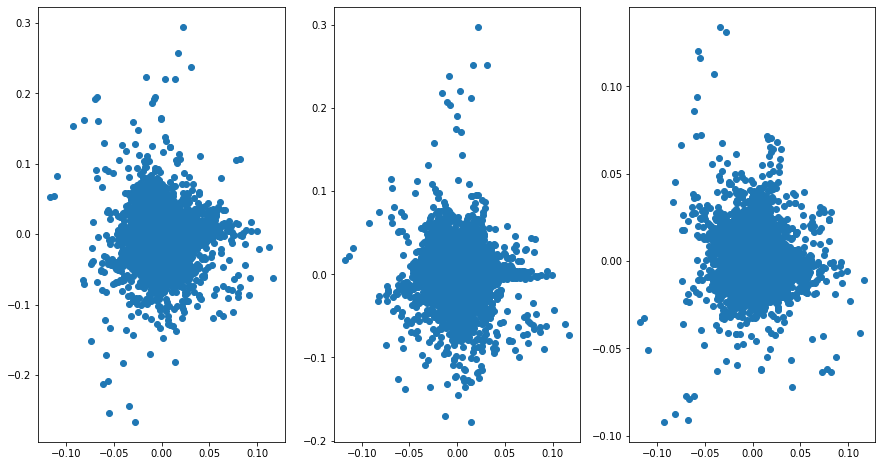

Plots for Bitcoin Cash


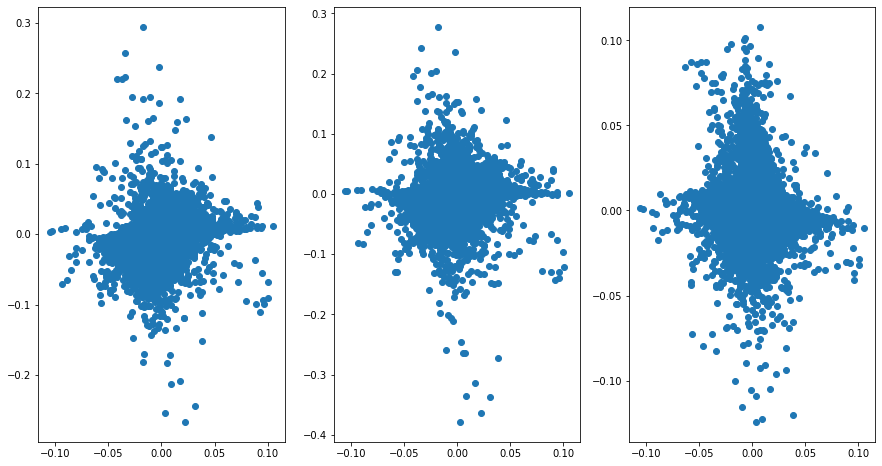

Plots for Binance Coin


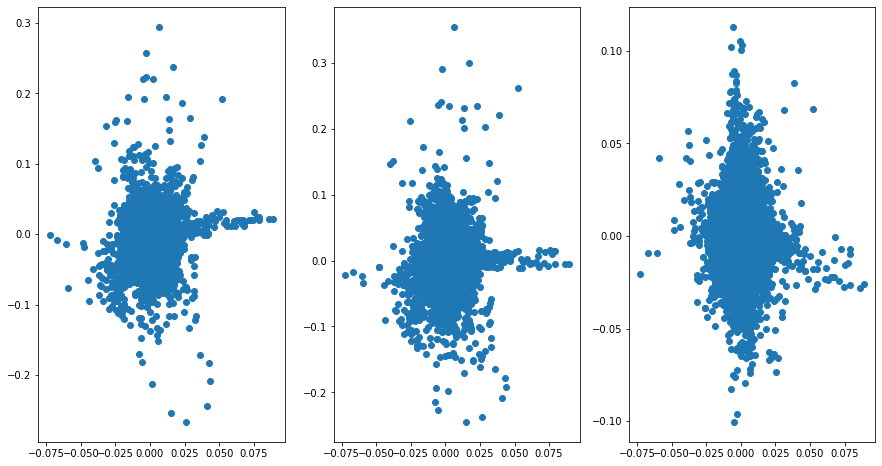

Plots for Ethereum


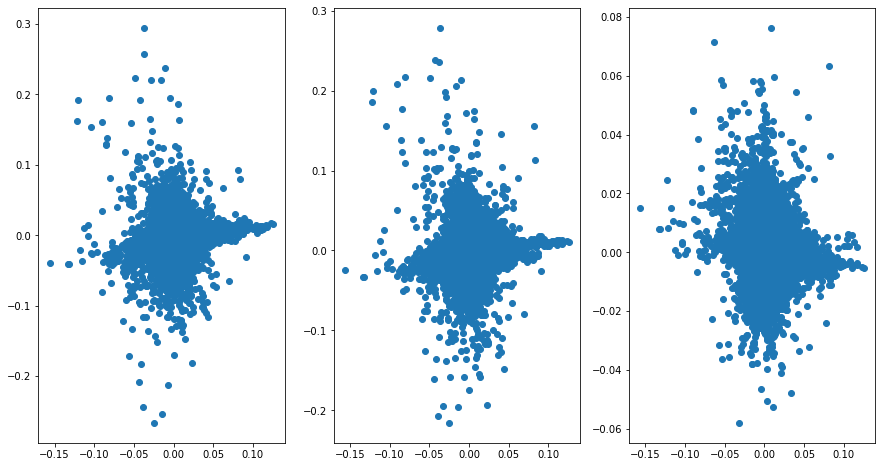

Plots for Monero


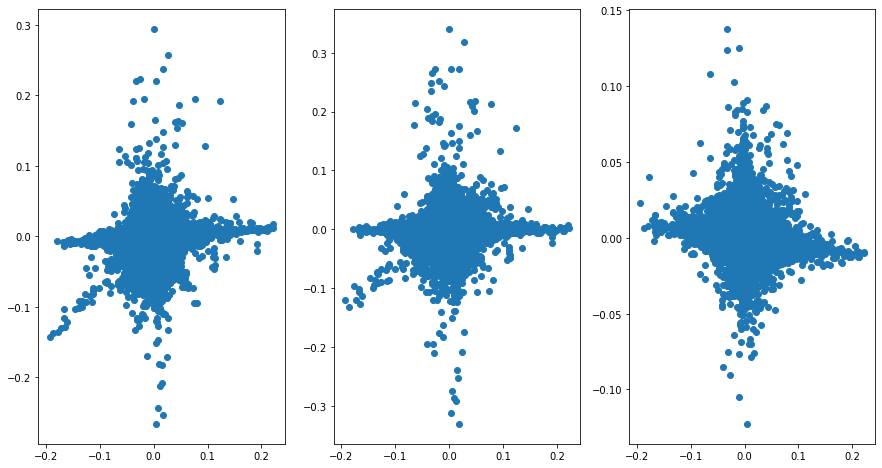

Plots for Litecoin


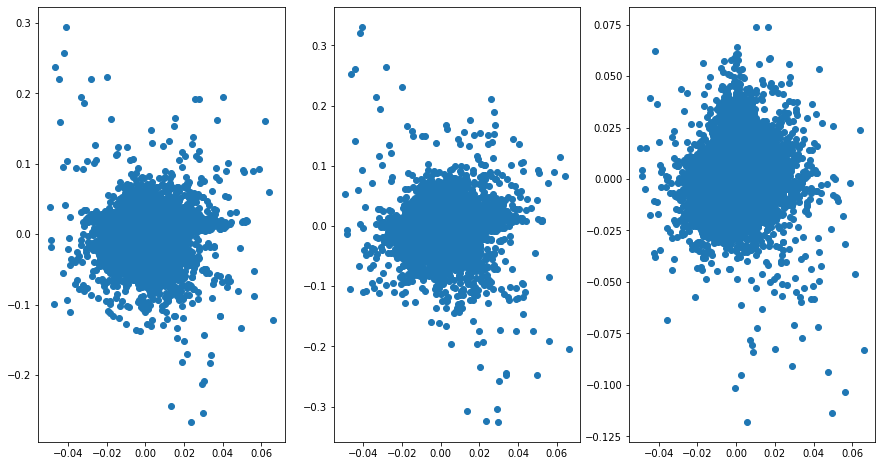

Plots for Stellar


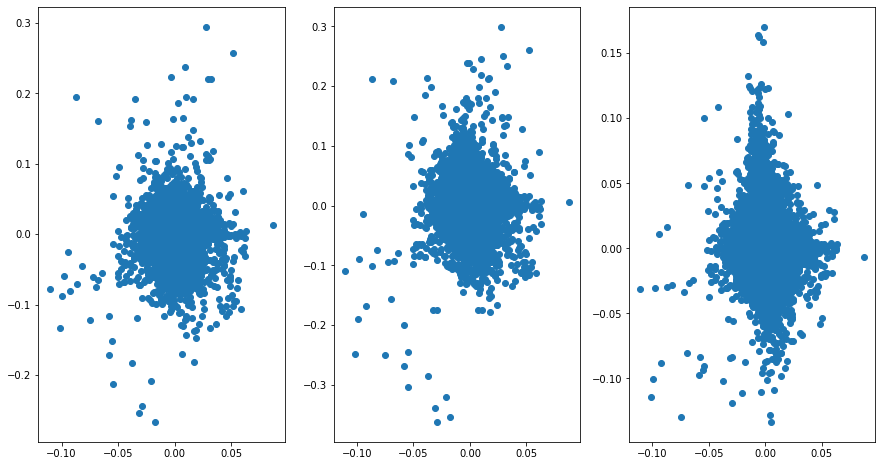

Plots for IOTA


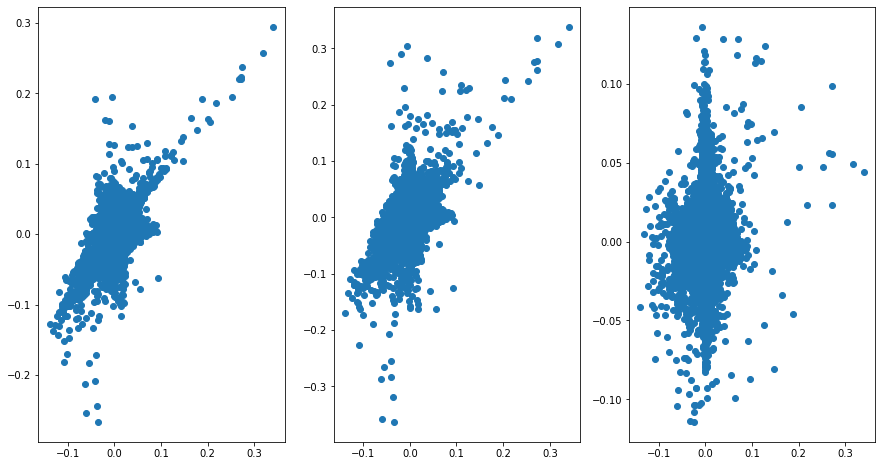

Plots for Dogecoin


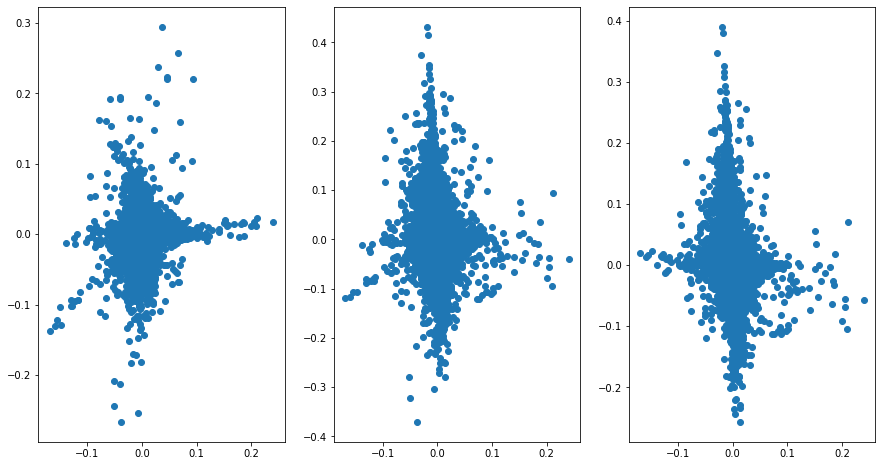

Plots for Maker


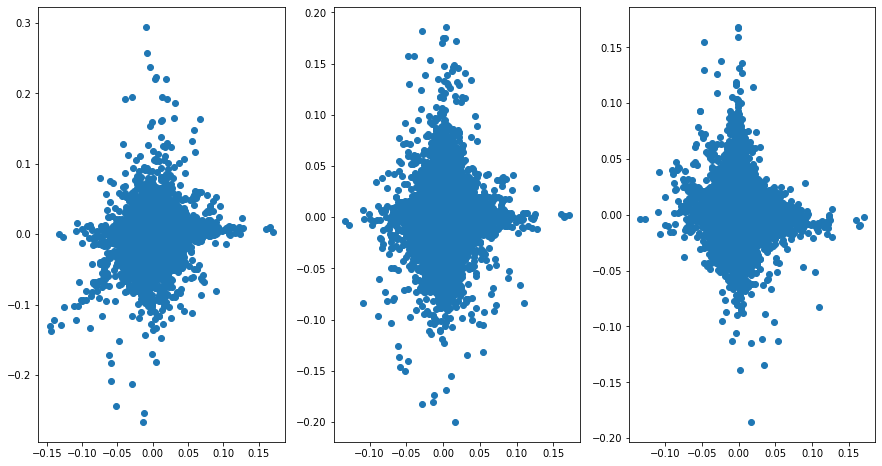

Plots for EOS.IO


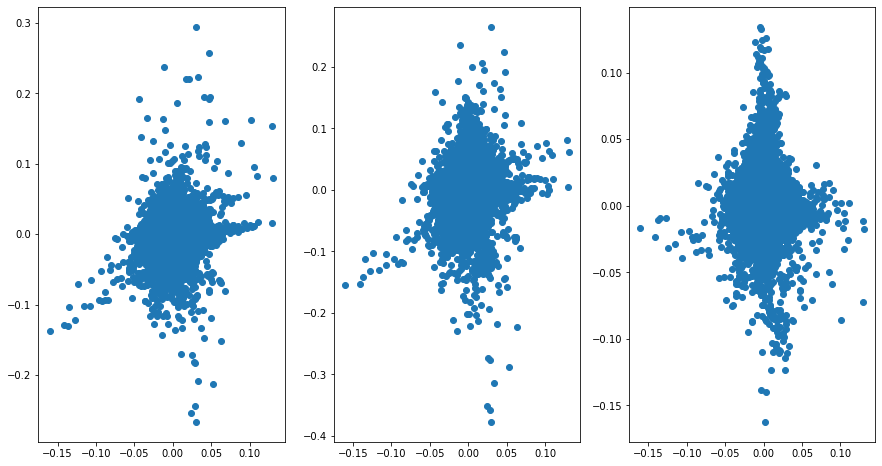

Plots for TRON


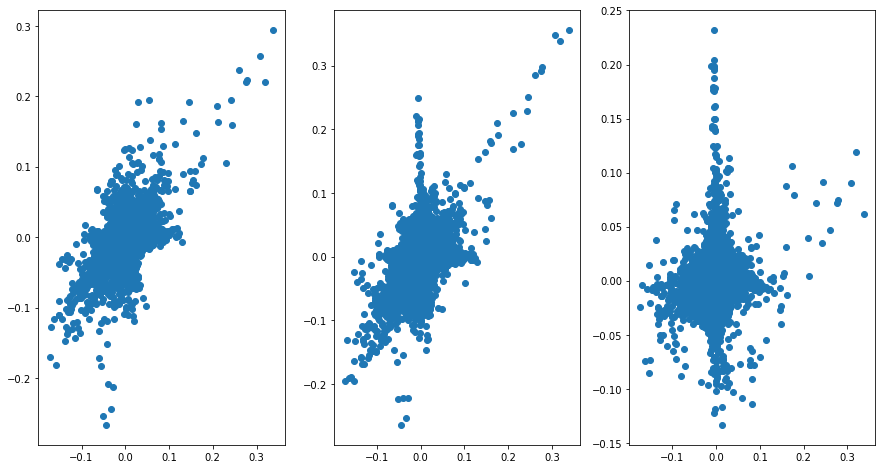

Plots for Cardano


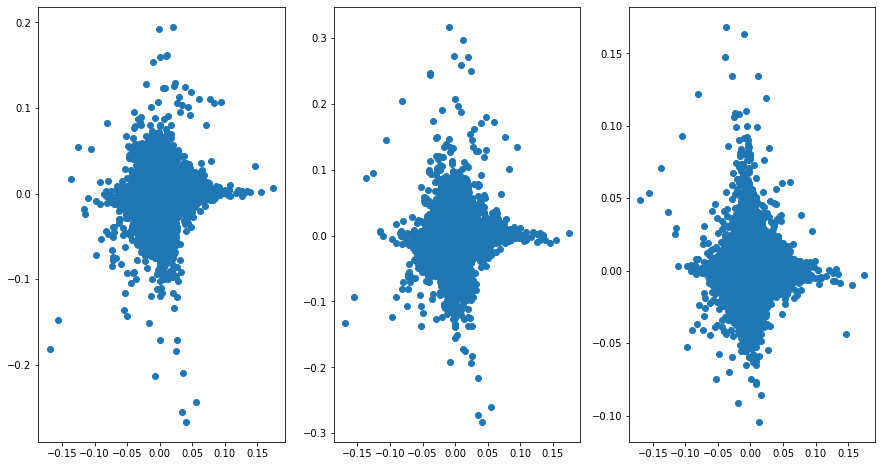

Plots for Ethereum Classic


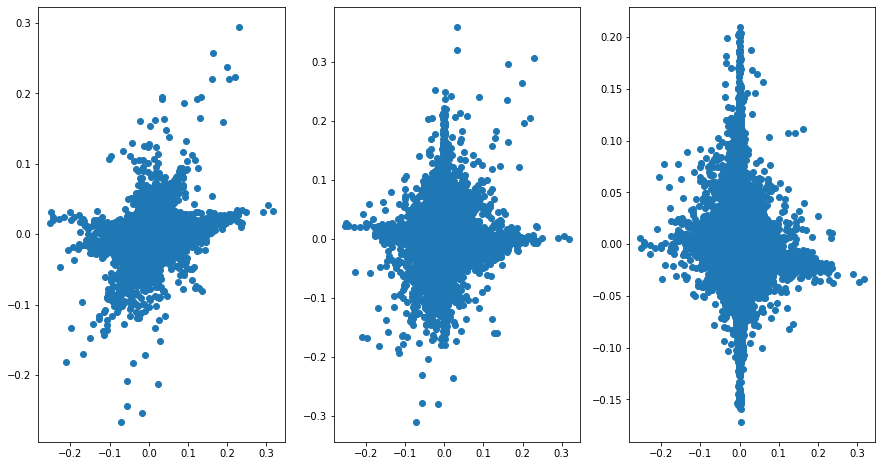

In [6]:
for id in ids:
    print("Plots for " + asset_names[id])
    asset = data[data.Asset_ID == id].set_index(keys = 'timestamp')
    asset['log_return'] = targets[asset_names[id]]
    asset['m'] = m
    asset['diff'] = targets[asset_names[id]] - m
    fig, axs = plt.subplots(1, 3, figsize = (15, 8))
    axs[0].scatter(asset.Target.fillna(0), asset['m'])
    axs[1].scatter(asset.Target.fillna(0), asset['log_return'])
    axs[2].scatter(asset.Target.fillna(0), asset['diff'])
    plt.show()

Sadly, this doesn't look to great for most of our currencies. But, looking at the plots for TRON and IOTA, maybe M and R will help with improving our predictions for these currencies.

### Preparing the Data

To predict the future closing prices for all currencies, we'll need data on all of them for training the regressor as well as for evaluating the overall model performance later on. The code below prepares all currency data, adding a column that includes information on the future closing price. We also store the information on currency weights and asset names in two extra lists, as we will drop both columns later.

In [7]:
all_currencies = []
all_currencies_eval = []
all_asset_names = []
weights = []
asset_ids = sorted(list(details.Asset_ID))

for id in asset_ids:
    currency = data[data.Asset_ID == id]
    currency.set_index('timestamp', inplace = True)
    currency = currency.reindex(all_timestamps)
    currency.sort_index(inplace = True)
    currency['close_16'] = currency.Close.shift(-16)
    currency['close_1'] = currency.Close.shift(-1)

    currency_eval = data_eval[data_eval.Asset_ID == id]
    currency_eval.set_index('timestamp', inplace = True)
    currency_eval = currency_eval.reindex(all_eval_timestamps, method = 'pad')
    currency_eval.sort_index(inplace = True)
    currency_eval['close_16'] = currency_eval.Close.shift(-16)
    currency_eval['close_1'] = currency_eval.Close.shift(-1)

    all_currencies.append(currency)
    all_currencies_eval.append(currency_eval)
    all_asset_names.append(currency.iloc[0].Asset_Name)
    weights.append(currency.iloc[0].Weight)

The first three variables contain the ids and asset names of the currencies for which we want to predict our target in the end. Obviously, the numbers have to match for this process to work properly. For now, we're only using Binance, but we could of course also add other currencies to the list. The next variables are used when adding technical indicators to the currency data. The last variable is the lookback period used when preparing the data for the RNN.

In [8]:
currencies = [13]
currencies_eval = [13]
asset_names = [all_asset_names[13]]

high = 'High'
low = 'Low'
close = 'Close'
volume = 'Volume'
fillna = False

lookback = 15

These are the parameters used for the `GrandientBoostingRegressor` for training the closing price predictions.

In [9]:
estimators = 50
test_size = 0.2
learning_rate = 0.1

These are the parameters used for the model that will be built by the keras tuner. 50 is the lower boundary of neurons to use in a layer, while 90 is the upper one. Within these limits, the tuner can also choose other neuron numbers with a step size of 10. The tuner can choose between one or two layers to add in addition to the two layers the model contains anyway. The rates to use for the dropout layers range between 0.2 and 0.5 with a step size of 0.1. The tuner can choose one of two learning rates and will use MAE as a loss measure. Additionally, it also calculates and displays the MSE during its trial runs. The `val_split` variable specifies the amount of data the tuner will use for validation. The variable `trial_executions` specifies the amount of times the tuner will execute a trial run with a certain set of parameters before trying the next combination. The maximum amount of overall trials the tuner will run is specified in `max_trials`.

In [10]:
min_neurons = 50
max_neurons =100   # changed from 50
step_neurons = 5   #changed from 10
min_layers = 1
max_layers = 5   #changed from 2
min_dropout = 0.2
max_dropout = 0.5
step_dropout = 0.1
learning_rates = [1e-2, 1e-3]
loss = 'mean_absolute_error'
loss_metrics = ['mse', 'mae']

val_split = 0.2
trial_executions = 2   #changed from 1
max_trials = 2        #changed from 2

The `n_split` variable specifies the number of time splits to use when training the RNN with the specified `time_gap` of 30 data instances between train and test set to avoid information leakage. The specified number of epochs and the batch size are used by both the keras tuner and the model training process. The `X_scaler` specifies the scaler to use for standardizing the data to a value range between zero and one to make the training process easier.

In [11]:
n_splits = 5
time_gap = 30
num_epochs = 4   #changed from 1
batch_size = 200  # changed from 100
X_scaler = MinMaxScaler(feature_range = (0, 1))

### The Functions

We'll use the following functions in order to prepare the data for our model, add technical indicators, evaluate the regressor and finally build the RNN.

This function just computes the log of the given column considering the passed period with a standard value of one, if no period value is specified.

In [12]:
def log_return(series, periods = 1):
    return np.log(series).diff(periods = periods)

The following functions add the chosen momentum, volume, trend and volatility indicators from the **ta** library. They were picked because they exhibited some of the highest correlation values to the targets of some currencies. As the strength of the correlation of individual indicators varies depending on the currency, this might not be an optimal choice. However, as arbitrarily adding all possible indicators to a currency and then filtering them out based on their correlation value takes a considerable amount of time to compute (and it will already take quite a bit of time with the regressor, the keras tuner and then finally training the model), I've decided to stick with this version.

In [13]:
def add_momentum_indicators(crypto):
    ao_indicator = ta.momentum.AwesomeOscillatorIndicator(high = crypto[high], low = crypto[low], fillna = fillna)
    rsi_indicator = ta.momentum.RSIIndicator(close = crypto[close], fillna = fillna)
    tsi_indicator = ta.momentum.TSIIndicator(close = crypto[close], fillna = fillna)
    crypto['momentum_ao'] = ao_indicator.awesome_oscillator()
    crypto['momentum_rsi'] = rsi_indicator.rsi()
    crypto['momentum_tsi'] = tsi_indicator.tsi()

In [14]:
def add_volume_indicators(crypto):
    fi_indicator = ta.volume.ForceIndexIndicator(close = crypto[close], volume = crypto[volume], fillna = fillna)
    mfi_indicator = ta.volume.MFIIndicator(high = crypto[high], low = crypto[low], close = crypto[close], volume = crypto[volume], fillna = fillna)
    crypto['volume_fi'] = fi_indicator.force_index()
    crypto['volume_mfi'] = mfi_indicator.money_flow_index()

In [15]:
def add_trend_indicators(crypto):
    aroon_indicator = ta.trend.AroonIndicator(close = crypto[close], fillna = fillna)
    macd = ta.trend.MACD(close = crypto[close], fillna = fillna)
    crypto['trend_aroon_indicator'] = aroon_indicator.aroon_indicator()
    crypto['trend_macd'] = macd.macd()

In [16]:
def add_volatility_indicators(crypto):
    donchian_channel = ta.volatility.DonchianChannel(high = crypto[high], low = crypto[low], close = crypto[close], fillna = fillna)
    crypto['volatility_dcp'] = donchian_channel.donchian_channel_pband()

This function prepares the data of the given currency before it is fed to the `GradientBoostingRegressor`. NA, positive and negative infinity values are replaced with zero to try to ensure that the resulting predictions all have the same length, as we will need them for calculating our additional model features later. We drop all the columns we don't need as features and assign the value we want to predict (the future closing price) as our y data. We then scale our feature and target data to a value range between zero and one and return them together with a list of all the column names of our features.

In [17]:
def prepare_regressor_data(currency):
    currency.fillna(0, inplace = True)
    currency.replace(np.inf, 0, inplace=True)
    currency.replace(-np.inf, 0, inplace=True)
    regressor_data = currency.drop(['Asset_ID', 'Time', 'Weight', 'Target', 'Asset_Name'], axis = 1)
    y_16 = regressor_data['close_16'].values
    y_1 = regressor_data['close_1'].values
    regressor_data = regressor_data.drop(['close_16', 'close_1'], axis = 1)
    X_data = X_scaler.fit_transform(regressor_data)
    return X_data, y_16, y_1, list(regressor_data.columns)

To help evaluate the performance of the regressor, we use the function below to visualize the training and test loss over the iterations.

In [18]:
def plot_deviance(regressor, X_test, y_test):
    test_score = np.zeros(estimators, dtype=np.float64)

    for i, y_pred in enumerate(regressor.staged_predict(X_test)):
        test_score[i] = regressor.loss_(y_test, y_pred)

    fig = plt.figure(figsize = (6, 6))
    plt.subplot(1, 1, 1)
    plt.plot(
        np.arange(estimators) + 1,
        regressor.train_score_,
        "b-",
        label = "Training Set Deviance",
    )
    plt.plot(
        np.arange(estimators) + 1, test_score, "r-", label = "Test Set Deviance"
    )
    plt.legend(loc = "upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance")
    fig.tight_layout()
    plt.show()

To check which of the features were most important for the predictions of our regressor, we can visualize the importance of each feature.

In [19]:
def plot_feature_importance(regressor, X_test, y_test, features):
    feature_importance = regressor.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize = (12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align = "center")
    plt.yticks(pos, np.array(features)[sorted_idx])
    plt.title("Feature Importance (MDI)")
    result = permutation_importance(
        regressor, X_test, y_test, n_repeats = 10, n_jobs = 4
    )
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert = False,
        labels = np.array(features)[sorted_idx],
    )
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()

To prepare the currency data we want to feed into the RNN, we drop the columns we don't need as well as the target, assign our target values as our prediction data and scale our feature variables. We then prepare the data according to the lookback period we've specified above, returning 3D-matrices of our feature data and target.

In [20]:
def prepare_data(currency_data):
    currency_data = currency_data.drop(['Asset_ID', 'Time', 'Weight', 'Asset_Name'], axis = 1)
    X_data = currency_data.drop(['Target'], axis = 1)
    y_data = currency_data['Target'].values
    X_data_ = X_scaler.fit_transform(X_data)

    X_rnn = []
    y_rnn = []

    for t in range(len(X_data_) - lookback):
        X_rnn.append(X_data_[t:(t + lookback)])
        y_rnn.append(y_data[(t + lookback)])

    X_rnn = np.array(X_rnn)
    y_rnn = np.array(y_rnn)

    return X_rnn, y_rnn

Recurrent Neural Networks (RNNs) have proven to be very effective when it comes to applying them on sequence data like our crypto data. The data instances of our input sequence are fed into a sequential structure of hidden states one at a time, where each state is also updated based on the input of the previous hidden state. That way, the hidden state at timestep t does not only receive information about the data instance t in our sequence, but also information from previous hidden states that have already processed previous input data. Computing updates and outputs is done in the same way for each state, as they share the same parameters. The unique structure of the RNN allows it to be able to process inputs of arbitrary length and use information from previous steps for the current computation.

The classical RNN layer suffers from multiple issues, the first one being that, as parameters are shared, by doing backpropagation through time, the gradients quickly accumulate which can be quite memory-consuming for larger sequences. The second one is the problem of exploding/vanishing gradients as they get backpropagated through the network. This is a specific problem of the tanh (and also sigmoid) activation function that is used in RNN structures.

At least the second issue is addressed by gated RNN structures like LSTM or GRU (while the answer to the first is truncated backprop). LSTMs were developed earlier and have more complex structure compared to GRUs. An LSTM cell contains three cells, that, generally speaking, are there to determine which information passed in from previous states to erase from the cell state (forget gate), which values of the state should be updated (input gate) and which elements of the cell state to pass on (output gate). This cell state is passed along as an additional value besides the computed hidden state value. In contrast, the GRU cell requires no cell state to be passed along and only contains a reset gate controlling which parts of the current state should be used to compute the next one and an update gate controlling how much information is passed on from previous timesteps. In practice, this simpler structure that also results in less parameters to optimize has proven to perform equally well compared to the LSTM.

The two cells below define an LSTM and an RNN network, respectively. Both have been defined in a way that they can be run using the keras tuner to find a decent hyperparameter configuration using the parameters specified at the beginning of this notebook. In order to stop our model from overfitting to the training data (which would actually mean we're able to capture the relationship to our target for the training data...) we add dropout, which during training, sets neurons to zero with a certain probability (which will also be chosen by the tuner). The set of dropped neurons for a layer changes randomly in every iteration, forcing the network to compensate for the lost information by letting other neurons learn it. As dropout has proven to be beneficial to combat overfitting in practice, it is now basically a standard to use.

Another hyperparameter to tune is the learning rate. If the learning rate is too small, the updates to the weights are minimal and the model does not converge (or rather only converges incredibly slowly) towards an optimum. A learning rate that is too high might lead to overshooting the optimum. Choosing a good learning rate is important, but also requires the proper optimization method to work really well. The Adam optimizer is the current go-to solution and adds the ideas of momentum and RMSProp to the standard stochastic gradient descent.

In [21]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit', min_value = min_neurons, max_value = max_neurons, step = step_neurons), return_sequences = True, input_shape = (lookback, currency.shape[1] - 5)))
    model.add(Dropout(hp.Float('Dropout_rate', min_value = min_dropout, max_value = max_dropout, step = step_dropout)))
    for i in range(hp.Int('n_layers', min_layers, max_layers)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value = min_neurons, max_value = max_neurons, step = step_neurons),return_sequences = True))
        model.add(Dropout(hp.Float('Dropout_rate', min_value = min_dropout, max_value = max_dropout, step = step_dropout)))
    model.add(LSTM(hp.Int('layer_2_neurons', min_value = min_neurons, max_value = max_neurons, step = step_neurons)))
    model.add(Dropout(hp.Float('Dropout_rate', min_value = min_dropout, max_value = max_dropout, step = step_dropout)))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values = learning_rates)
    model.compile(loss = loss, optimizer = Adam(learning_rate = hp_learning_rate), metrics = loss_metrics)
    return model

In [22]:
def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(hp.Int('input_unit', min_value = min_neurons, max_value = max_neurons, step = step_neurons), return_sequences = True, input_shape = (lookback, currency.shape[1] - 5)))
    model.add(Dropout(hp.Float('Dropout_rate', min_value = min_dropout, max_value = max_dropout, step = step_dropout)))
    for i in range(hp.Int('n_layers', min_layers, max_layers)):
        model.add(GRU(hp.Int(f'lstm_{i}_units', min_value = min_neurons, max_value = max_neurons, step = step_neurons),return_sequences = True))
        model.add(Dropout(hp.Float('Dropout_rate', min_value = min_dropout, max_value = max_dropout, step = step_dropout)))
    model.add(GRU(hp.Int('layer_2_neurons', min_value = min_neurons, max_value = max_neurons, step = step_neurons)))
    model.add(Dropout(hp.Float('Dropout_rate', min_value = min_dropout, max_value = max_dropout, step = step_dropout)))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values = learning_rates)
    model.compile(loss = loss, optimizer = Adam(learning_rate = hp_learning_rate), metrics = loss_metrics)
    return model

In order to compare the performance of our two neural networks, let's finally start with estimating future closing prices to add them as a feature.

### Estimating Future Closing Prices

As I've described above, I'm trying to estimate future closing prices in order to recreate parts of the components used to calculate our target (M and R), as they seem to exhibit a promising correlation at least for some of our currencies. As estimating M means that we will have to estimate future closing prices for all our 14 currencies (and I'm not patient enough to wait for hours), I wanted to test this idea using a model that quickly seems to produce at least decent results for estimating future closing prices. While tree-based models might not be an optimal choice for this task, and replacing this with a neural network might lead to better predictions and generalize better, I've decided to stick with the getting fast predictions approach.

This still takes long enough, as we're looping over all currencies to estimate the future closing price and timestep t+1 and that at t+16. We evaluate our MSE on the test set, and can also plot how our train and test loss evolved over time and which of our features was most important for the estimation process. As the plots take up a lot of space, I've uncommented them for now.

In [28]:
regressors_16 = []
regressors_1 = []

for currency in all_currencies:
    print("Estimating regressor for " + currency.iloc[-1].Asset_Name)
    X_data, y_data_16, y_data_1, column_names = prepare_regressor_data(currency)
    X_train_16, X_test_16, y_train_16, y_test_16 = train_test_split(X_data, y_data_16.ravel(), test_size = test_size)
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_data, y_data_1.ravel(), test_size = test_size)
    regressor_16 = GradientBoostingRegressor(verbose = 1, n_estimators = estimators, learning_rate = learning_rate, loss = 'squared_error')
    regressor_1 = GradientBoostingRegressor(verbose = 1, n_estimators = estimators, learning_rate = learning_rate, loss = 'squared_error')

    regressor_16.fit(X_train_16, y_train_16)
    mse = mean_squared_error(y_test_16, regressor_16.predict(X_test_16))
    print("The mean squared error on test set (16): {:.4f}".format(mse))
    regressors_16.append(regressor_16)

    regressor_1.fit(X_train_1, y_train_1)
    mse = mean_squared_error(y_test_1, regressor_1.predict(X_test_1))
    print("The mean squared error on test set (1): {:.4f}".format(mse))
    regressors_1.append(regressor_1)
    #plot_deviance(regressor_1, X_test_1, y_test_1)
    #plot_feature_importance(regressor_1, X_test_1, y_test_1, column_names)

Estimating regressor for Binance Coin
      Iter       Train Loss   Remaining Time 
         1       21481.4025            1.35m
         2       17435.2834            1.29m
         3       14154.0307            1.25m
         4       11493.1172            1.22m
         5        9333.4509            1.29m
         6        7580.6193            1.36m
         7        6158.5447            1.36m
         8        5003.5904            1.36m
         9        4067.2258            1.34m
        10        3305.5857            1.31m
        20         427.2676           54.47s
        30          68.3507           34.80s
        40          22.8868           17.67s
        50          16.8726            0.00s
The mean squared error on test set (16): 20.3879
      Iter       Train Loss   Remaining Time 
         1       21548.7788            1.29m
         2       17488.1352            1.27m
         3       14195.2963            1.24m
         4       11524.8866            1.22m
         5 

         1           2.1904            1.15m
         2           1.7856            1.14m
         3           1.4565            1.12m
         4           1.1876            1.17m
         5           0.9684            1.26m
         6           0.7901            1.32m
         7           0.6451            1.34m
         8           0.5266            1.36m
         9           0.4302            1.37m
        10           0.3514            1.37m
        20           0.0478            1.10m
        30           0.0072           39.49s
        40           0.0016           20.75s
        50           0.0008            0.00s
The mean squared error on test set (1): 0.0007
Estimating regressor for Ethereum
      Iter       Train Loss   Remaining Time 
         1      631113.9789            2.13m
         2      513256.9720            2.05m
         3      417536.2195            2.01m
         4      339723.8619            1.99m
         5      276473.2385            1.95m
         6      22

         2        6203.8652            1.17m
         3        5078.5753            1.14m
         4        4165.0310            1.11m
         5        3422.0900            1.09m
         6        2818.9217            1.07m
         7        2328.4619            1.09m
         8        1929.0244            1.15m
         9        1604.9378            1.18m
        10        1340.5685            1.20m
        20         332.9065           53.55s
        30         202.0626           33.51s
        40         180.8497           17.46s
        50         176.8241            0.00s
The mean squared error on test set (16): 179.7713
      Iter       Train Loss   Remaining Time 
         1        7588.1561            1.58m
         2        6199.6347            1.48m
         3        5074.1883            1.35m
         4        4160.5147            1.29m
         5        3417.5502            1.22m
         6        2815.1726            1.17m
         7        2324.1661            1.13m
    

Now, let's add all these predictions to lists to use for our feature calculation. To further evaluate the performance of our regressor models, we can compute the correlation between the actual values and our prediction and also visualize this using scatterplots (which I've again excluded for now).

In [29]:
regressor_preds_16 = []
regressor_preds_1 = []

for i in range(len(all_currencies)):
    print("Building plot for " + all_currencies[i].iloc[-1].Asset_Name)
    X_data, y_data_16, y_data_1, _ = prepare_regressor_data(all_currencies[i])

    regressor_16 = regressors_16[i]
    y_pred_16 = regressor_16.predict(X_data)
    regressor_preds_16.append(y_pred_16)
    print(np.corrcoef(y_pred_16, y_data_16.flatten())[0, 1])

    regressor_1 = regressors_1[i]
    y_pred_1 = regressor_1.predict(X_data)
    regressor_preds_1.append(y_pred_1)
    print(np.corrcoef(y_pred_1, y_data_1.flatten())[0, 1])

    print(len(y_pred_16), len(y_pred_1))

    #fig, axs = plt.subplots(1, 2, figsize = (15, 8))

    #axs[0].scatter(y_pred_16, y_data_16.flatten())
    #axs[1].scatter(y_pred_1, y_data_1.flatten())
    #plt.show()

Building plot for Binance Coin
0.9996840662133282
0.9998998691116667
744463 744463
Building plot for Bitcoin
0.9998950093221032
0.9999726312621644
744463 744463
Building plot for Bitcoin Cash
0.9995881196138721
0.999903107200635
744463 744463
Building plot for Cardano
0.9997374840400327
0.999950048907552
744463 744463
Building plot for Dogecoin
0.9996904716974796
0.9999467917162737
744463 744463
Building plot for EOS.IO
0.9993842202600932
0.9998781998484243
744463 744463
Building plot for Ethereum
0.9997543619375354
0.9999395436287577
744463 744463
Building plot for Ethereum Classic
0.9994966738316364
0.9998501956357593
744463 744463
Building plot for IOTA
0.9917658986378983
0.9922897242545896
744463 744463
Building plot for Litecoin
0.9997431523889676
0.9999378778121991
744463 744463
Building plot for Maker
0.9969071597720542
0.9972425195131852
744463 744463
Building plot for Monero
0.990433198040031
0.9908581773941283
744463 744463
Building plot for Stellar
0.999742995167228
0.999924

The correlation generally looks very promising for all our currencies and the plots seem to have a good shape (ignoring the few outliers). However, there seems to be another problem. For Dogecoin and Maker, the length of the prediction vectors does not match that of the other currencies. This suggests that for some timestamps, we're missing data on these two currencies.

### Add Estimations to the Data

So, let's calculate our estimation of R and M with our predicted values. To be able to calculate M, we need R arrays of the same size for all currencies. This means that we will have to take special care of our two renegade currencies and extend their R arrays to the desired length, indexing our predictions at the appropriate timestamps and filling the values for those timestamps for which data is missing for that currency with 0. After we have done this, we can calculate our M estimation.

In [30]:
weights = list(details.Weight)
close_logs = []
timestamps = []

for i in range(len(regressor_preds_16)):
    close_log = (regressor_preds_16[i] / regressor_preds_1[i]) - 1
    close_logs.append(close_log)

m = np.average(close_logs, axis = 0, weights = np.array(weights))

We can now finally prepare the data of the currencies we want to train by adding all our additional features.

In [31]:
training_currencies = []

for i in currencies:
    currency = all_currencies[i].drop(['close_16', 'close_1'], axis = 1).copy()

    currency['past_target'] = currency.Target.shift(16)
    currency['vwap_log_15'] = np.nan_to_num(log_return(currency.VWAP, 15), nan = 0.0, posinf = 0.0, neginf = 0.0)
    currency['close_log_15'] = np.nan_to_num(log_return(currency.Close, 15), nan = 0.0, posinf = 0.0, neginf = 0.0)
    currency['close_log'] = close_logs[i]
    currency['m'] = m

    add_momentum_indicators(currency)
    add_volume_indicators(currency)
    add_trend_indicators(currency)
    add_volatility_indicators(currency)
    currency.dropna(inplace = True)
    training_currencies.append(currency)
    print("Added features for currency " + currency.iloc[-1].Asset_Name)

C:\Users\sweet\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Added features for currency TRON


Let's check how well our features correlate with our target.

In [27]:
for currency in training_currencies:
    find_corr_features = currency.drop(['Asset_ID', 'Time', 'Weight'], axis = 1).corr(method = 'spearman')['Target'].abs().sort_values(ascending = False)
    print("Rank correlation for currency " + currency.iloc[-1].Asset_Name)
    print(find_corr_features[:])

Rank correlation for currency TRON
Target                   1.000000
past_target              0.060767
momentum_tsi             0.025531
High                     0.024875
Close                    0.024875
VWAP                     0.024861
Low                      0.024856
Open                     0.024835
momentum_rsi             0.023541
volume_mfi               0.022821
Count                    0.021194
trend_macd               0.020613
volume_fi                0.020602
momentum_ao              0.016582
Volume                   0.016099
trend_aroon_indicator    0.015959
close_log_15             0.015061
vwap_log_15              0.014878
close_log                0.012598
volatility_dcp           0.011911
m                        0.008547
Name: Target, dtype: float64


Well, this doesn't look too good. After we've gone through all the trouble of estimating M and R, their correlation to our target seems negligible. Evidently, these features have lost a lot of their predictive power somewhere along the way...

### Finding Good Hyperparameters

To help us find a good hyperparameter configuration for our models, let's use the keras tuner to evaluate different combinations of hyperparameters and choose the best one. For simplicity, let's use random search, which randomly picks a hyperparameter configuration from the available search space (all possible combinations). As executing and evaluating a set of hyperparameters takes quite a bit of time, I've set the number of trials and trial executions to a low number. However, this also means that finding the optimal hyperparameter configuration in our search space is unlikely. While the number of parameter combinations is too high to evaluate exhaustively (unless you are very patient or have a lot of computation power), we will probably always only approximate the optimal solution, but setting the number of trials to a higher value nontheless increases the chance.

In order to compare our two RNNs, we will let the tuner pick the best set of explored hyperparameters and later use these to build our and train our final models. The tuner will optimize one LSTM and one RNN model for each of the currencies we have specified above.

In [32]:
lstm_history = []
best_lstms = []
best_lstm_params = []

for currency in training_currencies:
    print("Starting LSTM run for " + currency.iloc[0].Asset_Name)
    X_rnn, y_rnn = prepare_data(currency)
    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 1)
    tuner = RandomSearch(build_lstm_model, objective = 'mse', max_trials = max_trials, executions_per_trial = trial_executions, overwrite = True)
    tuner.search(x = X_rnn, y = y_rnn, epochs = num_epochs, batch_size = batch_size, validation_split = val_split, callbacks = [early_stopping], verbose = 1)
    best_lstm_params.append(tuner.get_best_hyperparameters()[0])

Trial 2 Complete [00h 18m 01s]
mse: 1.807304852263769e-05

Best mse So Far: 1.767160665622214e-05
Total elapsed time: 00h 41m 26s
INFO:tensorflow:Oracle triggered exit


In [33]:
gru_history = []
best_grus = []
best_gru_params = []

for currency in training_currencies:
    print("Starting GRU run for " + currency.iloc[-1].Asset_Name)
    X_rnn, y_rnn = prepare_data(currency)
    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 1)
    tuner = RandomSearch(build_gru_model, objective = 'mse', max_trials = max_trials, executions_per_trial = trial_executions, overwrite = True)
    tuner.search(x = X_rnn, y = y_rnn, epochs = num_epochs, batch_size = batch_size, validation_split = val_split, callbacks = [early_stopping], verbose = 1)
    best_gru_params.append(tuner.get_best_hyperparameters()[0])

Trial 2 Complete [00h 15m 09s]
mse: 1.7685918464849237e-05

Best mse So Far: 1.7685918464849237e-05
Total elapsed time: 00h 36m 07s
INFO:tensorflow:Oracle triggered exit


### Training the RNNs

Now that we have a set of hyperparameters, we can finally train our actual models. We will use a time series split for training our data which can be seen as a substitute of cross-validation for time series data. Similar to cross-validation, we split our data into a certain number of chunks. But instead of using all but one of them for training and the remaining for testing, in our first run, we take the first chunk of data for training and use the second one for testing. We then increase our training set over the splits, adding the chunk we previously used for testing and using the next chunk in the time series as test data. This is repeated until all but the last data chunk have been used for training and the last for testing.

To be honest, I don't think this is entirely beneficial given our data. The way the time series split works, we're technically excluding the last portion of our data from the training process. However, if we take a look at the development of our currencies in the last time period, this seems like the most interesting part, given the large up- and downward trends in that time frame. Arguably, we might want to train our model on this part of the data to learn from it. Nevertheless, we'll stick with time splits for now, as, in general, they definitely do make sense for training RNNs.

In [312]:
iter = 0

for currency in training_currencies:
    print("Starting LSTM training for currency " + currency.iloc[-1].Asset_Name)
    currentFold = 1
    X_rnn, y_rnn = prepare_data(currency)
    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 1)
    timeSplits = TimeSeriesSplit(n_splits = n_splits, gap = time_gap)
    best_model = build_lstm_model(best_lstm_params[iter])
    history = []

    for train, test in timeSplits.split(X_rnn, y_rnn):
        print("Starting run " + str(currentFold) + " of " + str(n_splits))
        history.append(best_model.fit(X_rnn[train], y_rnn[train], epochs = num_epochs, batch_size = batch_size, validation_data = (X_rnn[test], y_rnn[test])))
        currentFold += 1

    best_lstms.append(best_model)
    lstm_history.append(history)
    iter += 1

Starting LSTM training for currency TRON
Starting run 1 of 5
1241/1241 [==============================] - 86s 66ms/step - loss: 0.0028 - mse: 2.7288e-05 - mae: 0.0028 - val_loss: 0.0019 - val_mse: 1.1360e-05 - val_mae: 0.0019
Starting run 2 of 5
2482/2482 [==============================] - 139s 56ms/step - loss: 0.0020 - mse: 1.2230e-05 - mae: 0.0020 - val_loss: 0.0028 - val_mse: 2.3233e-05 - val_mae: 0.0028
Starting run 3 of 5
3722/3722 [==============================] - 196s 53ms/step - loss: 0.0023 - mse: 1.5773e-05 - mae: 0.0023 - val_loss: 0.0018 - val_mse: 9.7369e-06 - val_mae: 0.0018
Starting run 4 of 5
4963/4963 [==============================] - 271s 55ms/step - loss: 0.0022 - mse: 1.4272e-05 - mae: 0.0022 - val_loss: 0.0030 - val_mse: 3.1761e-05 - val_mae: 0.0030
Starting run 5 of 5
6204/6204 [==============================] - 324s 52ms/step - loss: 0.0023 - mse: 1.7677e-05 - mae: 0.0023 - val_loss: 0.0036 - val_mse: 3.3669e-05 - val_mae: 0.0036


In [313]:
iter = 0

for currency in training_currencies:
    print("Starting GRU training for currency " + currency.iloc[-1].Asset_Name)
    currentFold = 1
    X_rnn, y_rnn = prepare_data(currency)
    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 1)
    timeSplits = TimeSeriesSplit(n_splits = n_splits, gap = time_gap)
    best_model = build_gru_model(best_gru_params[iter])
    history = []

    for train, test in timeSplits.split(X_rnn, y_rnn):
        print("Starting run " + str(currentFold) + " of " + str(n_splits))
        history.append(best_model.fit(X_rnn[train], y_rnn[train], epochs = num_epochs, batch_size = batch_size, validation_data = (X_rnn[test], y_rnn[test])))
        currentFold += 1

    best_grus.append(best_model)
    gru_history.append(history)
    iter += 1

Starting GRU training for currency TRON
Starting run 1 of 5
1241/1241 [==============================] - 58s 43ms/step - loss: 0.0052 - mse: 0.0013 - mae: 0.0052 - val_loss: 0.0022 - val_mse: 1.2426e-05 - val_mae: 0.0022
Starting run 2 of 5
2482/2482 [==============================] - 95s 38ms/step - loss: 0.0022 - mse: 1.2771e-05 - mae: 0.0022 - val_loss: 0.0028 - val_mse: 2.3406e-05 - val_mae: 0.0028
Starting run 3 of 5
3722/3722 [==============================] - 131s 35ms/step - loss: 0.0024 - mse: 1.6426e-05 - mae: 0.0024 - val_loss: 0.0019 - val_mse: 1.0118e-05 - val_mae: 0.0019
Starting run 4 of 5
4963/4963 [==============================] - 185s 37ms/step - loss: 0.0135 - mse: 0.0013 - mae: 0.0135 - val_loss: 0.0030 - val_mse: 3.1807e-05 - val_mae: 0.0030
Starting run 5 of 5
6204/6204 [==============================] - 226s 36ms/step - loss: 0.0025 - mse: 1.8455e-05 - mae: 0.0025 - val_loss: 0.0036 - val_mse: 3.3384e-05 - val_mae: 0.0036


After we've trained both our LSTM and our GRU, let's start evaluating the performance of our models using our entire training data.

In [34]:
y_lstm = []
predictions_lstm = []
iter = 0

for currency in training_currencies:
    print("Rerunning best LSTM model for currency " + currency.iloc[-1].Asset_Name)
    X_rnn, y_rnn = prepare_data(currency)
    train_pred = best_lstms[iter].predict(X_rnn)
    y_lstm.append(y_rnn)
    predictions_lstm.append(train_pred)

    fig, axs = plt.subplots(figsize = (15, 8))

    axs.scatter(train_pred.flatten(), y_rnn)
    plt.show()

    print(np.corrcoef(train_pred.flatten(), y_rnn)[0, 1])
    iter += 1

Rerunning best LSTM model for currency TRON


IndexError: list index out of range

Well, this doesn't seem to have worked at all. Our predictions seem to be completely off and barely have any relation to the target.

Displaying LSTM predictions for Binance Coin


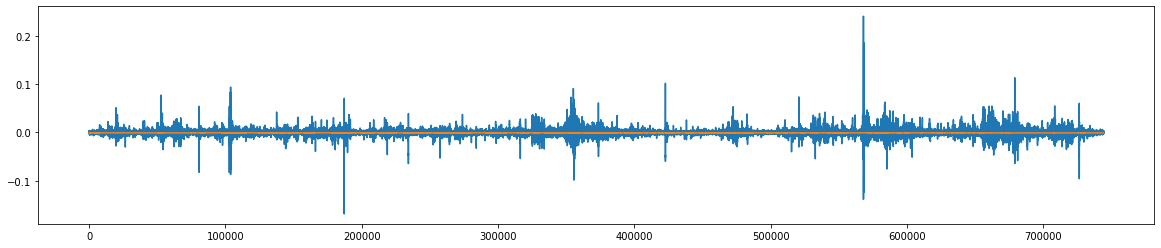

In [315]:
iter = 0

for i in currencies:
    print("Displaying LSTM predictions for " + all_asset_names[iter])
    fig, ax = plt.subplots(1, figsize = (20, 4))

    ax.plot(y_lstm[iter])
    ax.plot(predictions_lstm[iter])
    plt.show()
    iter += 1

Rerunning best GRU model for currency TRON


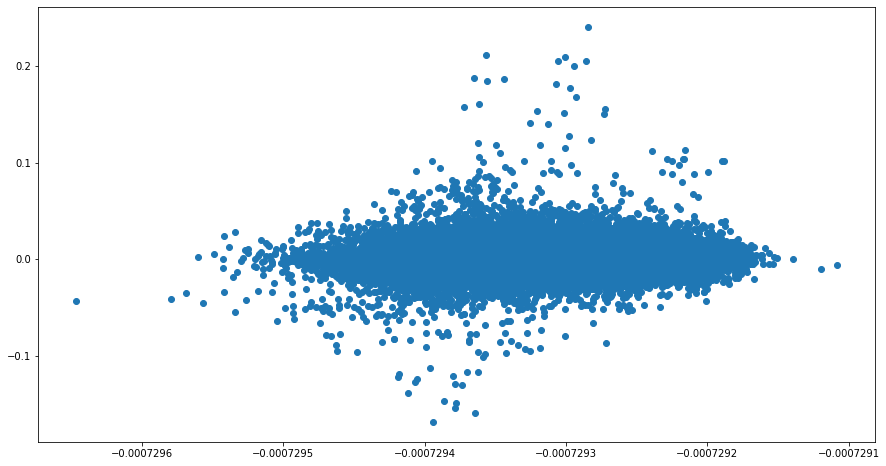

0.0009421392144807472


In [316]:
y_gru = []
predictions_gru = []
iter = 0

for currency in training_currencies:
    print("Rerunning best GRU model for currency " + currency.iloc[-1].Asset_Name)
    X_rnn, y_rnn = prepare_data(currency)
    train_pred = best_grus[iter].predict(X_rnn)
    y_gru.append(y_rnn)
    predictions_gru.append(train_pred)

    fig, axs = plt.subplots(figsize = (15, 8))

    axs.scatter(train_pred.flatten(), y_rnn)
    plt.show()

    print(np.corrcoef(train_pred.flatten(), y_rnn)[0, 1])
    iter += 1

The results we get from the GRU seem to be even worse.

Displaying GRU predictions for TRON


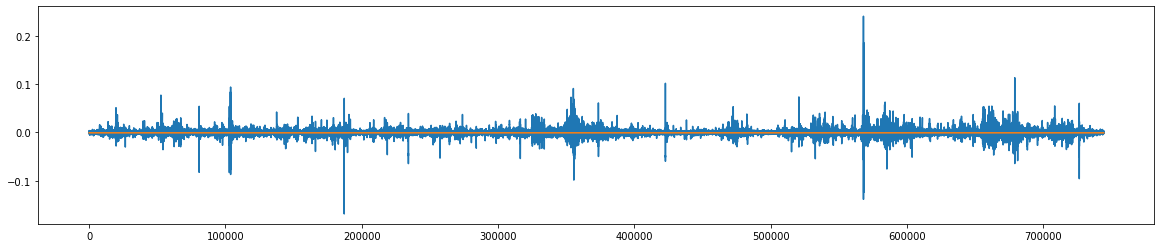

In [320]:
iter = 0

for i in currencies:
    print("Displaying GRU predictions for " + all_asset_names[i])
    fig, ax = plt.subplots(1, figsize = (20, 4))

    ax.plot(y_gru[iter])
    ax.plot(predictions_gru[iter])
    plt.show()
    iter += 1

### Evaluating the Models

Since we've already seen that our model doesn't perform too well even on our training data, naturally, it won't generalize well on unseen data either. Still, let's evaluate our models on the yet unseen test data we've prepared at the beginning. Since we've already gone through the process of training all our models, we just use them to make predictions on our test data. As we need to preprocess the data in the same way, we first let our regressors make their predictions.

In [338]:
regressor_preds_eval_16 = []
regressor_preds_eval_1 = []

for i in range(len(all_currencies_eval)):
    print("Building plot for " + all_currencies_eval[i].iloc[-1].Asset_Name)
    X_data, y_data_16, y_data_1, _ = prepare_regressor_data(all_currencies_eval[i])

    regressor_16 = regressors_16[i]
    y_pred_16 = regressor_16.predict(X_data)
    regressor_preds_eval_16.append(y_pred_16)
    print(np.corrcoef(y_pred_16, y_data_16.flatten())[0, 1])

    regressor_1 = regressors_1[i]
    y_pred_1 = regressor_1.predict(X_data)
    regressor_preds_eval_1.append(y_pred_1)
    print(np.corrcoef(y_pred_1, y_data_1.flatten())[0, 1])

    #fig, axs = plt.subplots(1, 2, figsize = (15, 8))

    #axs[0].scatter(y_pred_16, y_data_16.flatten())
    #axs[1].scatter(y_pred_1, y_data_1.flatten())
    #plt.show()

Building plot for Binance Coin
0.9978365597479343
0.9997267935562737
Building plot for Bitcoin
0.9970737087023492
0.9996111557822491
Building plot for Bitcoin Cash
0.99508023580064
0.9990410826388553
Building plot for Cardano
0.9990910935890516
0.9999039436977883
Building plot for Dogecoin
0.9980782502681518
0.9994950790167745
Building plot for EOS.IO
0.9963607978915299
0.9984198583253866
Building plot for Ethereum
0.9983826068726044
0.998948995256772
Building plot for Ethereum Classic
0.9967991051196066
0.9996642574512472
Building plot for IOTA
0.9976894796954023
0.9991659007023466
Building plot for Litecoin
0.9941683309335522
0.9988907459012925
Building plot for Maker
0.9971893026362983
0.9995000453188201
Building plot for Monero
0.996437715305633
0.9994289876609559
Building plot for Stellar
0.9976936249424274
0.9994834710246171
Building plot for TRON
0.9979937989529221
0.9997956390090165


As for our training data, our regressors seem to work pretty well on our test data, too. So, at least they seem to generalize just fine. Let's calculate our test R and M values and add them as features.

In [362]:
weights = list(details.Weight)
close_logs_eval = []

for i in range(len(regressor_preds_eval_16)):
    close_log_eval = (regressor_preds_eval_16[i] / regressor_preds_eval_1[i]) - 1
    close_logs_eval.append(close_log_eval)

m_eval = np.average(close_logs_eval, axis = 0, weights = np.array(weights))

Now, we just prepare all the currencies we want to evaluate in the same way we prepared our training data.

In [364]:
test_currencies = []

for i in currencies_eval:
    currency = all_currencies_eval[i].drop(['close_16', 'close_1'], axis = 1).copy()

    currency['past_target'] = currency.Target.shift(16)
    currency['vwap_log_15'] = np.nan_to_num(log_return(currency.VWAP, 15), nan = 0.0, posinf = 0.0, neginf = 0.0)
    currency['close_log_15'] = np.nan_to_num(log_return(currency.Close, 15), nan = 0.0, posinf = 0.0, neginf = 0.0)
    currency['close_log'] = close_logs_eval[i]
    currency['m'] = m_eval

    add_momentum_indicators(currency)
    add_volume_indicators(currency)
    add_trend_indicators(currency)
    add_volatility_indicators(currency)
    currency.dropna(inplace = True)
    test_currencies.append(currency)
    print("Added features for testing currency " + currency.iloc[0].Asset_Name)

Added features for evaluating currency TRON


Then, we can finally run our LSTM and our GRU on the test data.

Evaluating best LSTM model to evaluate currency TRON


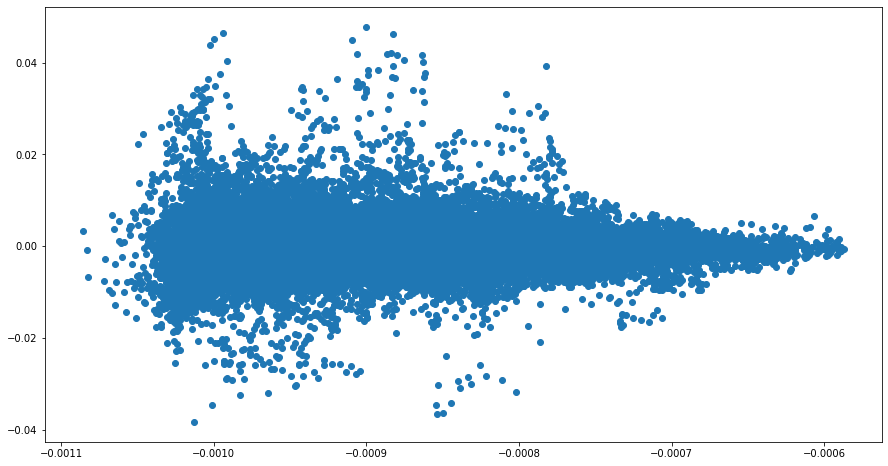

-0.016126994152254888


In [365]:
y_lstm_eval = []
predictions_lstm_eval = []
iter = 0

for currency in test_currencies:
    print("Evaluating best LSTM model to test currency " + currency.iloc[-1].Asset_Name)
    X_rnn, y_rnn = prepare_data(currency)
    train_pred = best_lstms[iter].predict(X_rnn)
    y_lstm_eval.append(y_rnn)
    predictions_lstm_eval.append(train_pred)

    fig, axs = plt.subplots(figsize = (15, 8))

    axs.scatter(train_pred.flatten(), y_rnn)
    plt.show()

    print(np.corrcoef(train_pred.flatten(), y_rnn)[0, 1])
    iter += 1

So, we've actually managed to get a negative correlation, which is an achievement in its own.

Displaying LSTM test predictions for currency TRON


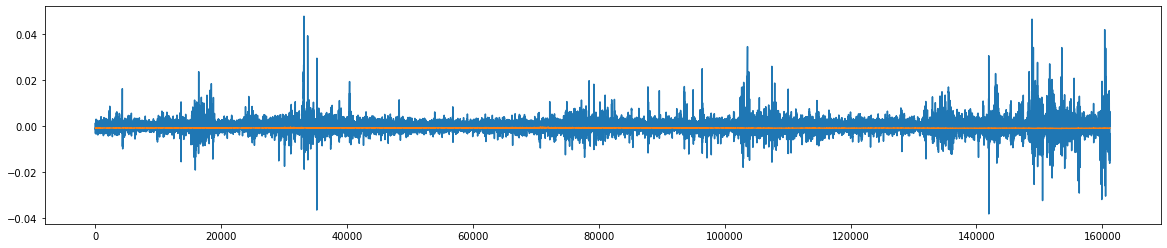

In [366]:
iter = 0

for i in currencies_eval:
    print("Displaying LSTM test predictions for currency " + all_asset_names[i])
    fig, ax = plt.subplots(1, figsize = (20, 4))

    ax.plot(y_lstm_eval[iter])
    ax.plot(predictions_lstm_eval[iter])
    plt.show()

Rerunning best GRU model to evaluate currency TRON


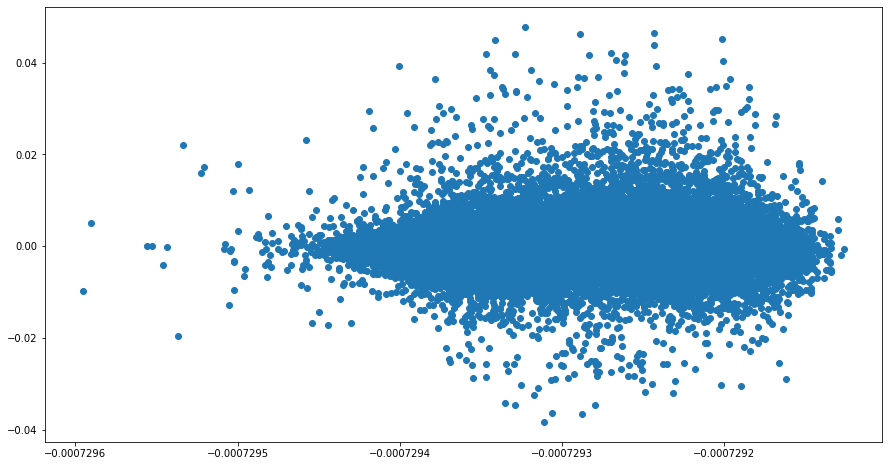

0.01978034196566963


In [367]:
y_gru_eval = []
predictions_gru_eval = []
iter = 0

for currency in test_currencies:
    print("Rerunning best GRU model to evaluate currency " + currency.iloc[-1].Asset_Name)
    X_rnn, y_rnn = prepare_data(currency)
    train_pred = best_grus[iter].predict(X_rnn)
    y_gru_eval.append(y_rnn)
    predictions_gru_eval.append(train_pred)

    fig, axs = plt.subplots(figsize = (15, 8))

    axs.scatter(train_pred.flatten(), y_rnn)
    plt.show()

    print(np.corrcoef(train_pred.flatten(), y_rnn)[0, 1])
    iter += 1

The GRU seems to hold up a bit better, but honestly, this could also just be pure coincidence.

Displaying GRU evaluation predictions for currency TRON


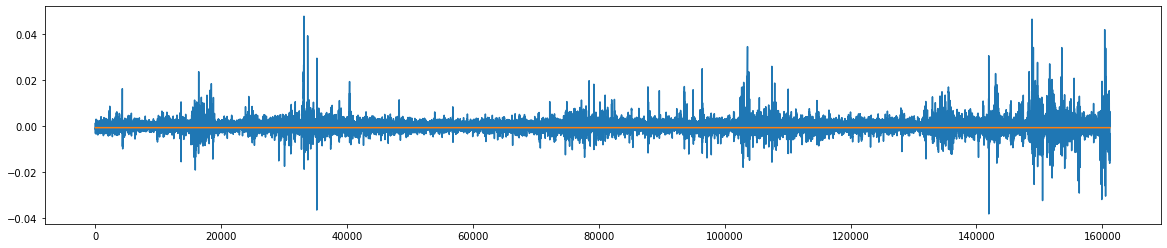

In [368]:
iter = 0

for i in currencies_eval:
    print("Displaying GRU evaluation predictions for currency " + all_asset_names[i])
    fig, ax = plt.subplots(1, figsize = (20, 4))

    ax.plot(y_gru_eval[iter])
    ax.plot(predictions_gru_eval[iter])
    plt.show()

Given the overall bad performance of both our models, I don't think we have a basis for deciding which one of the two works better. As we have set the trial runs of our tuner to a fairly limited number, the difference in results might just be due to different hyperparameter choices for one or the other model. Due to the non-deterministic nature of the training process, rerunning it would also change the results. All in all, I think the difference in performance itself is just too minimal to make any qualified statements in that regard.

While the results themselves are lacking, I still believe that at least for some of our currencies, trying to approximate the R and M values might be beneficial for our model performance. However, as I didn't have enough time left to look into this further, the results are as they are.

Still, this notebook can - if specified correctly - generate an individual model for all currencies based on the best performing model the keras tuner finds for that currency. I've only chosen a few currencies for demonstration since it takes quite a bit of time to run everything, but if you have a very good GPU, maybe it will be quite feasible to do this.